<a href="https://colab.research.google.com/github/Sucheta97/Gen-AI-GAN/blob/main/_Capstone_GAN_based_Image_Generation_using_CIFAR_10_using_DCGAN_CGAN_AND_WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




## 1. DCGAN (Deep Convolutional GAN)

### Definition

DCGAN is a GAN architecture that uses **deep convolutional neural networks** instead of fully connected layers for both the Generator and the Discriminator. This significantly improves image generation quality and training stability compared to vanilla GANs.

### Architecture

#### Generator

* Input: random noise vector ( z \sim \mathcal{N}(0,1) )
* Transposed Convolutions (ConvTranspose)
* Batch Normalization
* ReLU activations
* Output: generated image

#### Discriminator

* Convolution layers
* LeakyReLU activations
* Batch Normalization
* Sigmoid output (real vs fake probability)

---

### Objective Function

![image.png](attachment:image.png)

## loss Function
![image-6.png](attachment:image-6.png)

### Why DCGAN Works

* CNNs capture spatial structure
* BatchNorm stabilizes gradients
* Strided convolutions replace pooling
* Better feature hierarchy than dense GANs

---

### Example

**Dataset**: MNIST
**Input**: Random noise
**Output**: Digit-like images
**Limitation**: Cannot choose which digit is generated

---

### Applications

* Image synthesis (faces, objects)
* Super-resolution
* Data augmentation
* Artistic image generation

---

### Limitations

* No control over generated class
* Training instability
* Mode collapse

---

## 2. Conditional GAN (cGAN)

### Motivation

DCGAN generates images randomly without control.
Conditional GANs introduce **explicit conditioning information** to guide generation.

---

### Key Idea

Both Generator and Discriminator are conditioned on auxiliary information ( y ) such as:

* Class labels
* Attributes
* Text embeddings

---

### Architecture Change

![image-2.png](attachment:image-2.png)
Conditioning is implemented by:

* Concatenating labels with noise
* Embedding labels and injecting into CNN layers

---

### Objective Function

![image-3.png](attachment:image-3.png)

---

### loss

![image-7.png](attachment:image-7.png)

### Example

**Dataset**: CIFAR-10

| Label | Generated Class |
| ----- | --------------- |
| 0     | Airplane        |
| 1     | Automobile      |
| 2     | Bird            |
| 3     | Cat             |

**Result**: Controlled image generation by class label

---

### Applications

* Class-specific image generation
* Text-to-image synthesis
* Medical image generation by disease type
* Speech and voice synthesis

---

### Limitations

* Still uses Jensen–Shannon divergence
* Training instability persists
* Mode collapse not fully resolved

---

## 3. WGAN-GP (Wasserstein GAN with Gradient Penalty)

### Motivation

Standard GAN losses provide weak gradients when real and generated distributions do not overlap.
WGAN replaces divergence-based loss with **Wasserstein distance**, giving meaningful gradients.

---

### Wasserstein Distance

![image-4.png](attachment:image-4.png)

This measures the minimum cost of transforming one distribution into another.

---

### Architectural Changes

* Discriminator becomes **Critic**
* No sigmoid activation
* Outputs real-valued score
* Enforces 1-Lipschitz constraint

---

### What Is Critic Loss?

The critic does not classify real vs fake. Instead, it assigns higher scores to real samples and lower scores to fake samples


| Discriminator       | Critic              |
| ------------------- | ------------------- |
| Outputs probability | Outputs real number |
| Uses sigmoid        | No sigmoid          |
| Binary classifier   | Distance estimator  |
| Cross-entropy loss  | Wasserstein loss    |

### Why Critic Loss Works Better ?

- Approximates Wasserstein distance

- Provides meaningful gradients even when distributions do not overlap

- Training loss correlates with sample quality

- Reduces mode collapse

### Loss Functions
![image-8.png](attachment:image-8.png)

### Gradient Penalty

Ensures smoothness and Lipschitz continuity without weight clipping.

---

### Example

**Dataset**: CelebA
**Result**:

* Stable training
* Smooth loss curves
* High-quality facial images
* Minimal mode collapse

---

### Applications

* High-resolution image generation
* Video synthesis
* Audio and speech generation
* Scientific and physics simulations

---

## 4. Evolution Comparison

| Feature             | DCGAN | Conditional GAN | WGAN-GP |
| ------------------- | ----- | --------------- | ------- |
| CNN-based           | Yes   | Yes             | Yes     |
| Conditional control | No    | Yes             | Yes     |
| Stable loss         | No    | No              | Yes     |
| Mode collapse       | High  | Medium          | Low     |
| Training robustness | Low   | Medium          | High    |

---

## 5. Practical Example Pipeline

**CIFAR-10 Vehicle Images**

1. DCGAN → random vehicles
2. Conditional GAN → generate only trucks
3. WGAN-GP → sharper, stable truck images

---

## 6. When to Use Which GAN

| Scenario                  | Recommended Model   |
| ------------------------- | ------------------- |
| Learning GAN fundamentals | DCGAN               |
| Controlled generation     | Conditional GAN     |
| Production training       | WGAN-GP             |
| High-resolution synthesis | Conditional WGAN-GP |

---

## 7. Industry Applications

* Healthcare: rare disease data generation
* Autonomous driving: scenario simulation
* Gaming: texture and asset creation
* Retail: product image synthesis
* Media: animation and visual effects

## 8. Summary Table


| GAN Type | Loss Type                 | Key Parameters          | Stability |
| -------- | ------------------------- | ----------------------- | --------- |
| DCGAN    | Cross-Entropy             | (D(x), G(z))            | Low       |
| cGAN     | Cross-Entropy + Condition | (D(x,y), G(z,y))        | Medium    |
| WGAN-GP  | Wasserstein + GP          | (C(x), \lambda, \nabla) | High      |




# GAN-based Image Generation using CIFAR-10  
## DCGAN → Conditional GAN → WGAN-GP

### Dataset
CIFAR-10 (Canadian Institute for Advanced Research)

### Classes
- **Vehicles**: airplane, automobile, ship, truck  
- **Animals**: bird, cat, deer, dog, frog, horse

This notebook is **fully runnable** and generates images during training.


## 1. Imports & Global Configuration

In [ ]:

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

LATENT_DIM = 100
BATCH_SIZE = 64
EPOCHS = 30
NUM_CLASSES = 10


## 2. Load CIFAR-10 Dataset

In [ ]:

(x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()

# Normalize to [-1, 1]
x_train = (x_train.astype('float32') / 127.5) - 1.0

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(60000).batch(BATCH_SIZE)


## 3. Visualize Real CIFAR-10 Images

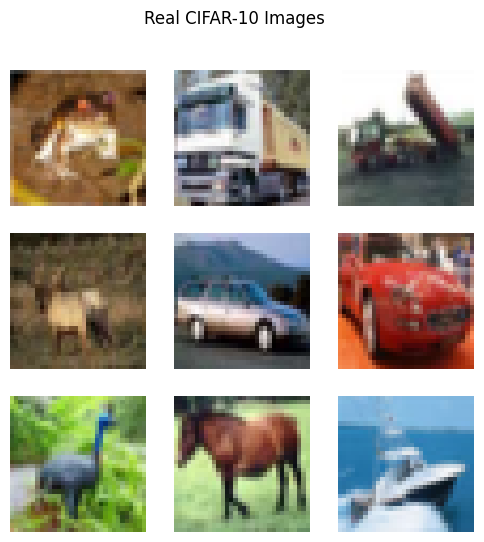

In [ ]:

plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow((x_train[i] + 1) / 2)
    plt.axis('off')
plt.suptitle("Real CIFAR-10 Images")
plt.show()



# 4. DCGAN (Baseline Image GAN)

DCGAN uses convolutional layers for stable image generation.


In [ ]:

def build_dcgan_generator():
    model = tf.keras.Sequential([
        layers.Dense(8*8*256, input_shape=(LATENT_DIM,)),
        layers.Reshape((8,8,256)),

        layers.Conv2DTranspose(128, 4, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(64, 4, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(3, 3, padding='same', activation='tanh')
    ])
    return model

def build_dcgan_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, 4, strides=2, padding='same',
                      input_shape=(32,32,3)),
        layers.LeakyReLU(0.2),

        layers.Conv2D(128, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

dcgan_gen = build_dcgan_generator()
dcgan_disc = build_dcgan_discriminator()


C:\Users\Suyashi144893\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Suyashi144893\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

bce = tf.keras.losses.BinaryCrossentropy()
gen_opt = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

@tf.function
def dcgan_train_step(images):
    noise = tf.random.normal([tf.shape(images)[0], LATENT_DIM])

    with tf.GradientTape() as gt, tf.GradientTape() as dt:
        fake = dcgan_gen(noise, training=True)
        real_out = dcgan_disc(images, training=True)
        fake_out = dcgan_disc(fake, training=True)

        g_loss = bce(tf.ones_like(fake_out), fake_out)
        d_loss = bce(tf.ones_like(real_out), real_out) +                  bce(tf.zeros_like(fake_out), fake_out)

    gen_opt.apply_gradients(zip(gt.gradient(g_loss, dcgan_gen.trainable_variables),
                                dcgan_gen.trainable_variables))
    disc_opt.apply_gradients(zip(dt.gradient(d_loss, dcgan_disc.trainable_variables),
                                 dcgan_disc.trainable_variables))
    return g_loss


## DCGAN Training & Output

DCGAN Epoch 5


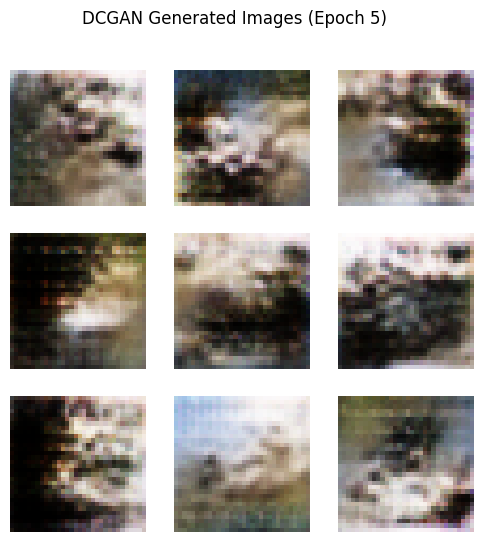

DCGAN Epoch 10


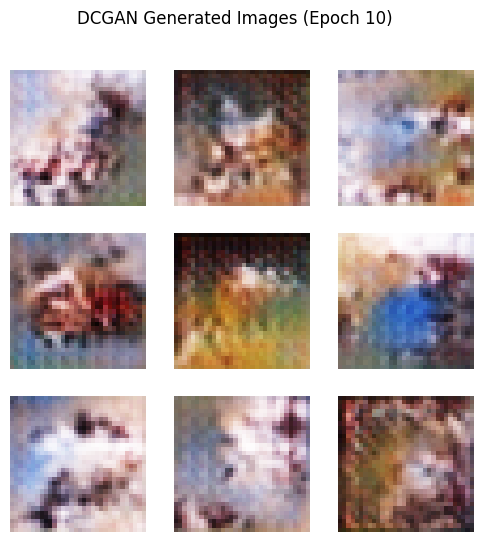

DCGAN Epoch 15


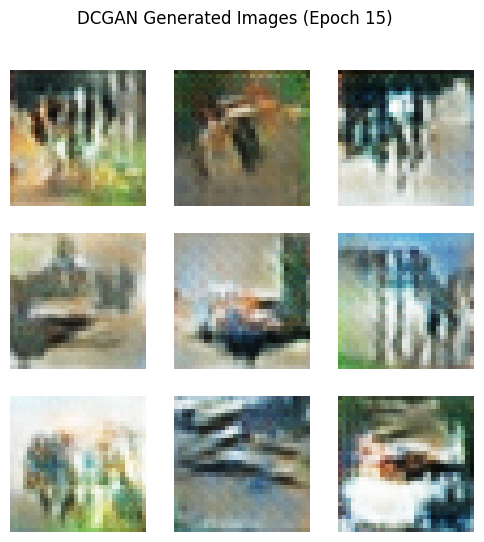

DCGAN Epoch 20


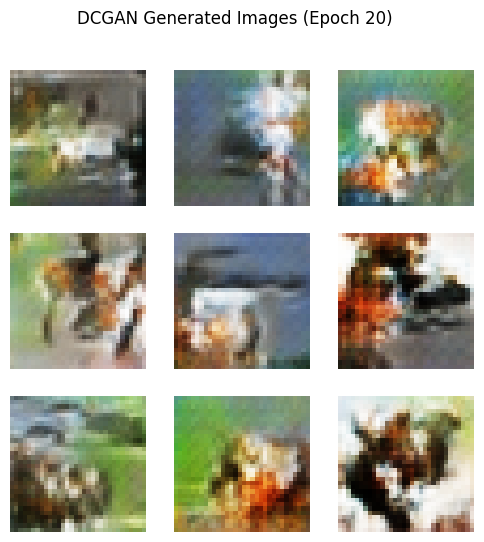

DCGAN Epoch 25


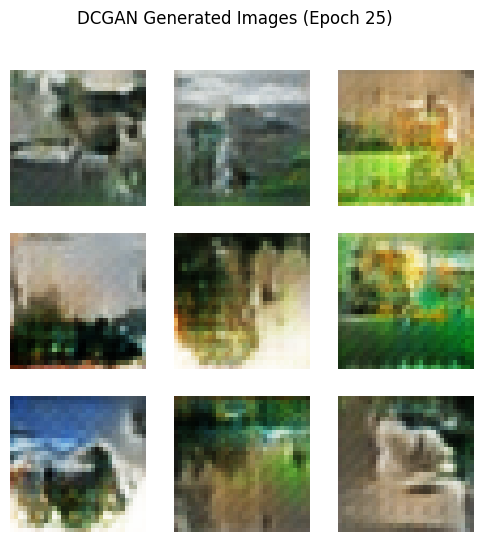

In [ ]:

def show_images(model, title):
    noise = tf.random.normal([9, LATENT_DIM])
    imgs = model(noise, training=False)

    plt.figure(figsize=(6,6))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow((imgs[i] + 1) / 2)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

for epoch in range(1, EPOCHS+1):
    for imgs, _ in dataset:
        dcgan_train_step(imgs)

    if epoch % 5 == 0:
        print(f"DCGAN Epoch {epoch}")
        show_images(dcgan_gen, f"DCGAN Generated Images (Epoch {epoch})")



# 5. Conditional GAN (Vehicle vs Animal)

Generator and Discriminator are conditioned on CIFAR-10 labels.


In [ ]:

def build_cgan_generator():
    noise = layers.Input(shape=(LATENT_DIM,))
    label = layers.Input(shape=(1,), dtype='int32')

    label_emb = layers.Embedding(NUM_CLASSES, LATENT_DIM)(label)
    label_emb = layers.Flatten()(label_emb)

    x = layers.Concatenate()([noise, label_emb])
    x = layers.Dense(8*8*256)(x)
    x = layers.Reshape((8,8,256))

    x = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(x)
    x = layers.ReLU()(x)

    out = layers.Conv2DTranspose(3, 3, padding='same', activation='tanh')(x)
    return tf.keras.Model([noise, label], out)

cgan_gen = build_cgan_generator()



## Conditional Generation Demo

Generate images by specifying class labels:
- Vehicle classes: 0,1,8,9
- Animal classes: 2–7


In [ ]:

def generate_conditional_images(model, label):
    noise = tf.random.normal([9, LATENT_DIM])
    labels = tf.ones((9,1), dtype=tf.int32) * label
    imgs = model([noise, labels], training=False)

    plt.figure(figsize=(6,6))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow((imgs[i] + 1) / 2)
        plt.axis('off')
    plt.suptitle(f"Conditional GAN – Class {label}")
    plt.show()

generate_conditional_images(cgan_gen, label=1)



# 6. WGAN-GP (Industry-Preferred Stable GAN)

Uses Wasserstein loss + Gradient Penalty.


In [ ]:

def build_critic():
    model = tf.keras.Sequential([
        layers.Conv2D(64, 4, strides=2, padding='same',
                      input_shape=(32,32,3)),
        layers.LeakyReLU(0.2),

        layers.Conv2D(128, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

critic = build_critic()
wgan_gen = build_dcgan_generator()


In [ ]:

LAMBDA_GP = 10
gen_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.0, beta_2=0.9)
crit_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.0, beta_2=0.9)

def gradient_penalty(real, fake):
    alpha = tf.random.uniform([tf.shape(real)[0],1,1,1])
    interpolated = real + alpha * (fake - real)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = critic(interpolated, training=True)

    grads = tape.gradient(pred, interpolated)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1,2,3]))
    return tf.reduce_mean((norm - 1.0) ** 2)


In [ ]:

@tf.function
def wgan_train_step(images):
    noise = tf.random.normal([tf.shape(images)[0], LATENT_DIM])

    with tf.GradientTape() as gt, tf.GradientTape() as ct:
        fake = wgan_gen(noise, training=True)

        real_score = critic(images, training=True)
        fake_score = critic(fake, training=True)

        gp = gradient_penalty(images, fake)

        c_loss = tf.reduce_mean(fake_score) - tf.reduce_mean(real_score) + LAMBDA_GP * gp
        g_loss = -tf.reduce_mean(fake_score)

    crit_opt.apply_gradients(zip(ct.gradient(c_loss, critic.trainable_variables),
                                  critic.trainable_variables))
    gen_opt.apply_gradients(zip(gt.gradient(g_loss, wgan_gen.trainable_variables),
                                 wgan_gen.trainable_variables))

    return g_loss


## WGAN-GP Training & Output

In [ ]:

for epoch in range(1, EPOCHS+1):
    for imgs, _ in dataset:
        wgan_train_step(imgs)

    if epoch % 5 == 0:
        print(f"WGAN-GP Epoch {epoch}")
        show_images(wgan_gen, f"WGAN-GP Generated Images (Epoch {epoch})")



## Final Comparison

- **DCGAN**: Good baseline image quality  
- **Conditional GAN**: Controlled generation (vehicle vs animal)  
- **WGAN-GP**: Most stable and industry-preferred  


